# UMPC-Food101 - Multimodal(Image+Text) Classification
## Decision-Level Fusion

In [1]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from transformers import BertModel, BertConfig,AutoModel

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from UMPC_Dataset import UMPC_FoodDataset
from ImageModels.TransferModel import Model
from ImageModels.Visualizations import plot_confusion,plot_Fusion_samples

In [2]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
url = "https://api.easypost.com/something"
returnResponse = requests.get(url, verify=False)
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
os.environ['CURL_CA_BUNDLE'] = ''
import warnings
warnings.filterwarnings("ignore") 

a=15
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
random.seed(a)
np.random.seed(a)
torch.manual_seed(a)
torch.cuda.manual_seed(a)

/home1/ece1/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.easypost.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## Some Constants and hyperparameters

In [3]:
OUTPUT_SIZE =101
epochs=15
batch_size=10
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Test set split and Test DataLoader

In [4]:
test_transforms = transforms.Compose([transforms.Resize((384,384)),
                                  #transforms.CenterCrop(resize),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                       [0.229, 0.224, 0.225])])

In [5]:
Test_set=UMPC_FoodDataset(targ_dir="./datasets/Food101" ,phase="test", mode="all",transform=test_transforms)
Testloader= DataLoader(Test_set, batch_size=batch_size, shuffle=False,num_workers=0)

In [6]:
print(f"{len(Test_set)} samples loaded.")
print(f"Total no. of batches in testloader : {len(Testloader)}")

22716 samples loaded.
Total no. of batches in testloader : 2272


### Dataset (Image-Text pair) example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 384, 384])
Image datatype: torch.float32 



Text(0.5, 1.0, 'Class: 1 : baby_back_ribs')

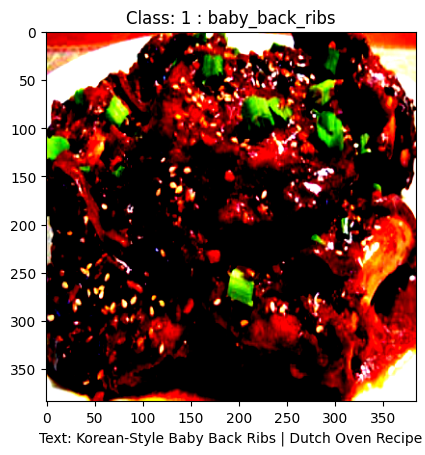

In [7]:
sample=Test_set[300]
img,txt_tokens,txt,lbl=sample

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")

figure, ax = plt.subplots()
ax.imshow(sample[0].permute(1,2,0))
ax.set_xlabel(f"Text: {sample[2]}",fontsize=10)
ax.set_title(f"Class: {lbl} : {Test_set.idx_to_class[sample[3]]}")
#figure.savefig(f"Img_txtpair.png", dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


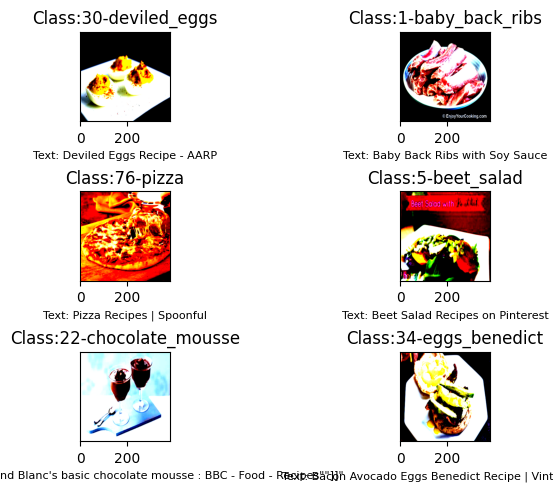

In [8]:
plot_Fusion_samples(Test_set)

## 2. Image-Text Models

### 2.1 Image Model (`VIT_b_16`: Vision Transformer Pretrained on IMAGENET1K_SWAG_Weights )

In [9]:
image_model=Model("vit_b_16",num_classes=OUTPUT_SIZE,weights="IMAGENET1K_SWAG_E2E_V1",device=device)
image_model.load_state_dict(torch.load("Saved_weights/best_weights_UMPC_vit_b_16.pt"))

Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main


<All keys matched successfully>

### 2.2 Text Model (`BERT`)

In [10]:
class TextModel(nn.Module):
    def __init__(self, dim_text_repr=768, num_class=101):
        super().__init__()
        config = BertConfig()
        self.textEncoder= BertModel(config).from_pretrained('bert-base-uncased')    
        self.linear = nn.Linear(dim_text_repr, num_class)

    def forward(self, x):
        text = x
        hidden_states = self.textEncoder(**text)  # B, T, dim_text_repr
        e_i = F.dropout(hidden_states[1]) 
        return self.linear(e_i)
    
text_model = TextModel(num_class=OUTPUT_SIZE).to(device)
text_model.load_state_dict(torch.load("./Saved_weights/BERT_UMPC_best_weights.pt"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

## 3. Loss Function

In [11]:
loss_fn = nn.CrossEntropyLoss()

## 4. Late Fusion (`Decision-Level Fusion`)

In [12]:
def Fusion(model1,model2,dataloader,loss_fn,device='cuda'):

    model1.eval()
    model2.eval()
    total_loss=0.0
    total_acc=0.0
    label=[]
    preds=[]
    

    tk=tk=tqdm(dataloader, desc=("Epoch"+"[Test]"+str(1)+"/"+str(1)) )


    for t,data in enumerate(tk):
        images,tokens,_,labels=data
        
        images=images.to(device)
        texts = {k: v.to(device) for k, v in tokens.items()}
        
        labels = labels.to(device)        
        label.append(labels.detach().cpu().numpy())
        
        y_pred1=model1(images)
        y_pred2=model2(texts)
        
        y_pred=y_pred1+y_pred2
        
        
        loss=loss_fn(y_pred,labels)
        total_loss+=loss.item()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        preds.append(y_pred_class.detach().cpu().numpy())
        
        total_acc += (y_pred_class == labels).sum().item()/len(y_pred)
        tk.set_postfix({"loss":"%.3f" %float(total_loss/(t+1)),"acc":"%.4f" %float(total_acc/(t+1))})
        
    label = [item for sublist in label for item in sublist]
    preds = [item for sublist in preds for item in sublist]
    
    return (total_loss/len(dataloader)),(total_acc/len(dataloader)),label ,preds

In [13]:
test_loss ,test_acc ,label ,preds=Fusion(image_model,text_model,Testloader,loss_fn)

Epoch[Test]1/1: 100%|█| 2272/2272 [12:18<00:00,  3.08it/s, loss=0.291, acc=0.938


#### Save predictions

In [15]:
import pandas as pd
score_fusion={
    "Predictions":preds,
    "Labels": label
}

df=pd.DataFrame(score_fusion)
df.to_csv("score_fusion.csv",index=False)

## 5. Visualize Output 

### 5.1 Plot samples with predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


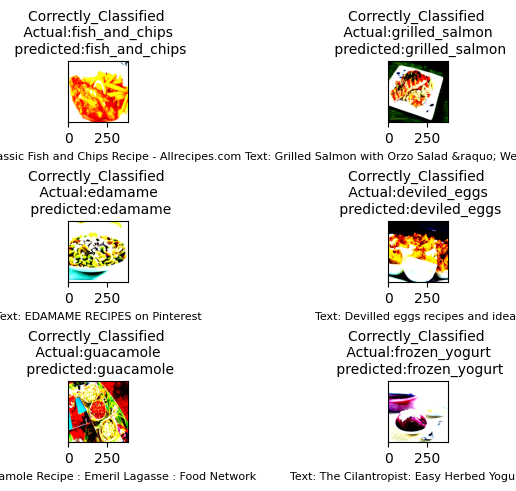

In [18]:
plot_Fusion_samples(Test_set,preds)

### 5.2 Preformance Metrics

In [19]:
from sklearn.metrics import classification_report,precision_recall_fscore_support 

Report=classification_report(label ,preds,digits=4)
print(Report)

              precision    recall  f1-score   support

           0     0.9607    0.9402    0.9503       234
           1     0.9563    0.9910    0.9733       221
           2     0.9777    0.9690    0.9733       226
           3     0.8818    0.8739    0.8778       222
           4     0.7438    0.8000    0.7709       225
           5     0.9457    0.9330    0.9393       224
           6     0.9196    0.9196    0.9196       224
           7     0.9585    0.9244    0.9412       225
           8     0.9567    0.9779    0.9672       226
           9     0.9406    0.8879    0.9135       214
          10     0.9781    0.9654    0.9717       231
          11     0.9688    0.9559    0.9623       227
          12     0.9685    0.9348    0.9513       230
          13     0.9552    0.9682    0.9616       220
          14     0.9649    0.9524    0.9586       231
          15     0.9770    0.9339    0.9550       227
          16     0.9231    0.8036    0.8592       224
          17     0.9780    